### Comparing mass balance in four column runs
### 1. 3D column run
### 2. no-subgrid (intermediate-model) column run
### 2. subgrid (intermediate-model) column run with del_max = del_ex = depr_depth = 0 (trial parameters)
### 2. subgrid (intermediate-model) column run with del_max = 0.4, del_ex = 0.2 , depr_depth = 0.15 (typical LCP)

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PreProcessing/PyScript')
import readdata

In [2]:
path ='/Users/ajc/FUSE/simulations/tests/ats-intermediate-ngee-up/single_column/'
path = "/Users/ajc/Core/simulations/tests/ats-intermediate-ngee-up/single_column/"
Simulations = [['CESM_5050_R10_3D'], ['CESM_5050_R10_B'],['CESM_5050_R30_B'],['CESM_5050_R30_BX']]
Sim_name = ['S1','S2','S3','S3X']
f_name = ['ats_vis_surface_data.h5','ats_vis_surface_column_0_data.h5', 'ats_vis_surface_column_0_data.h5','ats_vis_surface_column_0_data.h5']
snow_f_name = ['ats_vis_snow_data.h5','ats_vis_snow_column_0_data.h5', 'ats_vis_snow_column_0_data.h5','ats_vis_snow_column_0_data.h5']
ss_f_name = ['ats_vis_data.h5','ats_vis_column_0_data.h5', 'ats_vis_column_0_data.h5','ats_vis_column_0_data.h5']

var_name = ['surface', 'surface_column_0','surface_column_0','surface_column_0']
snow_var_name = ['snow', 'snow_column_0','snow_column_0','snow_column_0']
ss_var_name = ['domain', 'column_0','column_0','column_0']


In [3]:
to_day_mm = 86400 * 1000
to_day_year_mm = 86400 * 365 * 1000
to_mm = 1000.
surface_area = 1#61.92
molar_den = 55500.

In [4]:
def getSurfaceData(i,var,hdf_file='ats_vis_surface_data.h5',yr_len=365, average=True):
    Data = []
    for s in Simulations[i]:
        infile = os.path.join(path,s,hdf_file)
        dx=h5py.File(infile,'r')
        d = np.array(readdata.GetSurfVarFromVis_All(infile,var)[var])
        if (average):
            d = d.mean(axis=1)
        else:
            d = d.sum(axis=1)
        L = len(d)%yr_len
        if L >0:
            d = d[:-L]
        Data.append(d)
    d = dict()
    d[var] = np.concatenate(Data)
    
    return d

In [5]:
def Evaporation(yr_len):
    #time = 2006 + np.linspace(0,94,94,dtype='int')
    d3_sf = []
    sf_change = 0
    Evap = dict()
    for i,sim in enumerate(Simulations):
        var = var_name[i] + '-evaporative_flux'
        d1 = getSurfaceData(i, var, hdf_file=f_name[i],yr_len=yr_len)[var]
        d2 = [x*to_day_mm for x in d1]
        d3_sf = [x*to_day_mm for x in d2] 
        Evap[Sim_name[i]] = np.reshape(d1,(-1,yr_len)).mean(axis=1)*to_day_year_mm
        print (len(Evap[Sim_name[i]]))
    return Evap

In [6]:
E_annual = Evaporation(yr_len=365)

5
5
5
5


In [29]:
def SF_WaterContent(yr_len=365):
    SF_WC = dict()
    for i,sim in enumerate(Simulations):
        var = var_name[i] + '-water_content'
        d1_sf = getSurfaceData(i, var, hdf_file=f_name[i],yr_len=yr_len)[var]

        factor = 1/(molar_den *surface_area)*to_mm
        d2_sf = [x*factor for x in d1_sf]
        d3_sf = np.reshape(d2_sf,(-1,yr_len))
        d_c = []
        for d in d3_sf:
            d_c.append(d[-1] - d[0])
        SF_WC[Sim_name[i]] = d_c
        print (len(SF_WC[Sim_name[i]]),SF_WC[Sim_name[i]])
    return SF_WC

In [30]:
SF_WC = SF_WaterContent(yr_len=365)

5 [0.0, 0.0, 6.962402929939931, -6.962402929939931, 0.0]
5 [0.0, 0.0, 7.229120223241786, -7.229120223241786, 0.0]
5 [0.0, 0.0, 8.744225782354867, -8.744225782354869, 0.0]
5 [0.0, 0.0, 5.715687215785874, -5.715687215668908, 0.0]


In [9]:
def getSubSurfaceData(i,hdf_file='visdump_data.h5',yr_len=365,average=False):
    Data = []
    if 'column' in ss_var_name[i]:
        var = ss_var_name[i] + '-water_content'
    else:
        var = 'water_content'
    hdf_file = ss_f_name[i]
    #print ('getSubSurfaceData: ',i, var,hdf_file)
    for s in Simulations[i]:
        infile=os.path.join(path,s,hdf_file)
        #print (infile)
        d1_ss = readdata.GetSumSurfVarFromVis(file=infile, var=var)[var]
        L = len(d1_ss)%yr_len
        if L >0:
            d1_ss = d1_ss[:-L]
            
        Data.append(d1_ss)
    d = np.concatenate(Data)
    
    return d

In [31]:
from multiprocessing import Pool
from functools import partial
num_processors = 4

pool=Pool(processes = num_processors)

def SS_WaterContent(yr_len=365):
    SS_WC = dict()

    prod_x=partial(getSubSurfaceData,hdf_file=f_name[0],yr_len=yr_len)
    global DataS1, DataS2, DataS3
    DataS1, DataS2, DataS3, DataS4 = pool.map(prod_x,[i for i in range(len(Simulations))])
    d1 = [DataS1, DataS2,DataS3, DataS4]
    for i in range(4):
        d1_ss = d1[i]
        factor = 1/(molar_den *surface_area)*to_mm
        d2_ss = [x*factor for x in d1_ss]
        d3_ss = np.reshape(d2_ss,(-1,yr_len))
        d_c = []
        for d in d3_ss:
            d_c.append(d[-1] - d[0])
        SS_WC[Sim_name[i]] = np.array(d_c)
        print (SS_WC[Sim_name[i]])
    return SS_WC

In [32]:
SS_WC = SS_WaterContent(yr_len=365)

[69.49113818 89.64675106  6.11202279 -5.98408695 -8.78068533]
[66.80960127 92.38116227  5.98853875 -5.23992982 -8.28910635]
[ 67.7789983   91.97162699   5.45862636  -1.26222914 -12.33478714]
[ 68.7805122   78.96584267  17.55178043 -15.19012273   0.8304029 ]


In [33]:
def Snow_WaterContent(yr_len=365):
    SF_SC = dict()
    for i,sim in enumerate(Simulations):
        if 'column' in snow_var_name[i]: 
            var = snow_var_name[i] + '-snow_water_equivalent'
        else:
            var = 'snow-water_equivalent'

        d1_sf = getSurfaceData(i, var, hdf_file=snow_f_name[i],yr_len=yr_len)[var]

        factor = 1./(surface_area)*to_mm
        d2_sf = [x*factor for x in d1_sf]
        d3_sf = np.reshape(d2_sf,(-1,yr_len))
        d_c = []
        for d in d3_sf:
            d_c.append(d[-1] - d[0])
        SF_SC[Sim_name[i]] = np.array(d_c)
        print (SF_SC[Sim_name[i]])
    return SF_SC

In [34]:
SNOW_WC = Snow_WaterContent(yr_len=365)

[ 73.49153081 -30.39315673  51.24771654 -56.74586857 -27.227042  ]
[ 72.93009726 -29.93951194  53.93625464 -58.59648728 -27.95920213]
[ 74.68522357 -31.27299022  55.66912394 -60.59983394 -28.08938059]
[ 79.05769116 -24.60411025  44.88799064 -48.45018884 -29.14460123]


In [14]:
print (len(E_annual['S1']), len(SS_WC['S1']), len(SF_WC['S1']), len(SNOW_WC['S1']))
Total_S1 = E_annual['S1'] + SS_WC['S1'] + SF_WC['S1'] + SNOW_WC['S1'] 
Total_S2 = E_annual['S2'] + SS_WC['S2'] + SF_WC['S2'] + SNOW_WC['S2'] 
Total_S3 = E_annual['S3'] + SS_WC['S3'] + SF_WC['S3'] + SNOW_WC['S3'] 
Total_S3X = E_annual['S3X'] + SS_WC['S3X'] + SF_WC['S3X'] + SNOW_WC['S3X'] 

5 5 5 5


In [15]:
print (Total_S1, Total_S2,Total_S3, Total_S3X) 

[271.04934641 241.0641075  267.67086538 196.35346198 319.37246965] [269.64662733 240.43666292 284.47669907 201.54367047 324.89931719] [270.64411973 240.73224381 283.54288225 199.73606474 327.39550584] [270.44019194 241.11916345 283.01391422 199.71943977 328.75637964]


In [16]:
forcing_watershed_FM = h5py.File("/Users/ajc/Core/PreProcessing/ats-intermediate-ngee/data/SNAP/CESM-RCP8.5-2006-2100_dm1985-2015-FM_2006.h5",'r')

In [17]:
d1 = forcing_watershed_FM['precipitation rain [m s^-1]']
d2 = forcing_watershed_FM['precipitation snow [m SWE s^-1]']
rain_mm = np.reshape(d1,(-1,365)).mean(axis=1)*86400*365*1000
snow_mm = np.reshape(d2,(-1,365)).mean(axis=1)*86400*365*1000
precip_annual = snow_mm + rain_mm
r1 = np.array(d1)*86400*1000
r2 = np.array(d2)*86400*1000
precip_daily = r1 + r2

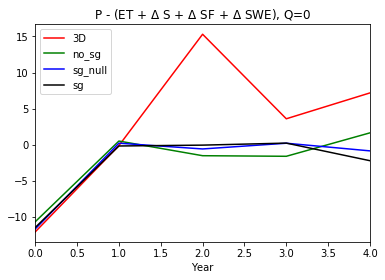

In [40]:
plt.plot(precip_annual[0:5] - Total_S1, 'r-',label='3D')
plt.plot(precip_annual[0:5] - Total_S2, 'g-',label='no_sg')
plt.plot(precip_annual[0:5] - Total_S3, 'b-',label='sg_null')
plt.plot(precip_annual[0:5] - Total_S3X,'k-',label='sg')
plt.title(r'P - (ET + $\Delta$ S + $\Delta$ SF + $\Delta$ SWE), Q=0')
plt.xlim(0,4)
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

In [19]:
print (E_annual['S1'], E_annual['S2'], E_annual['S3'], E_annual['S3X'])
print (SS_WC['S1'], SS_WC['S2'], SS_WC['S3'], SS_WC['S3X'])
print (SF_WC['S1'], SF_WC['S2'], SF_WC['S3'], SF_WC['S3X'])
print (SNOW_WC['S1'], SNOW_WC['S2'], SNOW_WC['S3'], SNOW_WC['S3X'])

[128.06667742 181.81051317 203.34872312 266.04582043 355.38019698] [129.9069288  177.99501259 217.32278545 272.60920779 361.14762566] [128.17989786 180.03360704 213.67090617 270.34235361 367.81967357] [122.60198858 186.75743103 214.85845593 269.07543855 357.07057797]
[69.49113818368278, 89.64675105662536, 6.112022789769981, -5.984086953547376, -8.780685333444126] [66.80960126599166, 92.38116226639977, 5.988538754776528, -5.23992982162963, -8.28910634566273] [67.77899829606395, 91.97162699451292, 5.458626355706656, -1.26222914313621, -12.334787139483524] [68.7805121951751, 78.96584266579521, 17.551780432469968, -15.190122725940455, 0.8304028966631449]
[0.0, 0.0, 6.962402929939931, -6.962402929939931, 0.0] [0.0, 0.0, 7.229120223241786, -7.229120223241786, 0.0] [0.0, 0.0, 8.744225782354867, -8.744225782354869, 0.0] [0.0, 0.0, 5.715687215785874, -5.715687215668908, 0.0]
[73.4915308052356, -30.39315673271225, 51.24771653912046, -56.74586857377538, -27.22704199579907] [72.93009726131524, -29